In [1]:
%matplotlib inline
!pip install tensorboardcolab

import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorboardcolab

Using TensorFlow backend.


In [2]:
# load cifar10 dataset 
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 10s 0us/step


In [3]:
# reshape (None, 1) -> (None)
y_train, y_test = [np.reshape(y_train, [-1]), np.reshape(y_test, [-1])]

# normalization 
x_train, x_test = [(x_train - x_train.max()) / (x_train.max() - x_train.min()),
                   (x_test - x_test.max()) / (x_test.max() - x_test.min())]

# N class
n_classes = 10
print('image shape : {}, label shape : {} '.format(x_train.shape, y_train.shape))
print('image shape : {}, label shape : {} '.format(x_test.shape, y_test.shape))
print('train minimun : {}, train_maximum : {} '.format(x_train.min(), x_train.max()))
print('tests minimun : {}, test_maximum : {} '.format(x_test.min(), x_test.max()))

image shape : (50000, 32, 32, 3), label shape : (50000,) 
image shape : (10000, 32, 32, 3), label shape : (10000,) 
train minimun : 0.0, train_maximum : 1.0 
tests minimun : 0.0, test_maximum : 1.0 


In [4]:
temp = x_train
ratio = int(len(x_train) * 0.7)
ratio_end = int(len(x_train) * 1.0)

x_train = temp[0:ratio, :, :, :]
x_validation = temp[ratio:ratio_end , :, :, :]

y_train_label = y_train[0:ratio]
y_validation_label = y_train[ratio:ratio_end ]

print(y_train_label[:10]) # label이 one_hot encoding상태가 아니다.

print(x_train.shape, y_train_label.shape)
print(x_validation.shape, y_validation_label.shape)

[6 9 9 4 1 1 2 7 8 3]
(35000, 32, 32, 3) (35000,)
(15000, 32, 32, 3) (15000,)


## Data Provider

In [0]:
class DataProvider(object):
    def __init__(self, x, y):
        self.epoch_count = 0
        
        self.data = x
        self.label = y
        
        npr.seed(42)
        
        self.indices = self.generate_indices()
        
    def generate_indices(self):
        indices = list(range(len(self.data)))
        npr.shuffle(indices)
        
        return indices
    
    def next_batch(self, batch_size):
        idx = batch_size
        if len(self.indices) < batch_size:
            print("all data consumed, epoch + 1")
            self.epoch_count += 1
            self.indices = self.generate_indices()
    
        target_indices = self.indices[:batch_size]
        del self.indices[:batch_size]
        
        return self.data[target_indices] , self.label[target_indices]

In [0]:
def cifar_generator(data, labels, batch_size=32):
    start_idx = 0
    num_step = len(data) // batch_size
    indexes = np.arange(0, len(data))
    while True:
        if start_idx >= num_step-1:
            np.random.shuffle(indexes)
            start_idx = 0
        else:
            start_idx += 1            
        batch_index = indexes[start_idx*batch_size:
                              (start_idx+1)*batch_size]

        batch_data = data[batch_index]
        batch_label = labels[batch_index]

        yield batch_data, batch_label

## Model A : Build

In [7]:
graph = tf.Graph()
with graph.as_default() :
    xs = tf.placeholder(tf.float32, (None, 32, 32, 3), name='xs') # 32*32 = 1024
    ys = tf.placeholder(tf.int32, (None), name='ys')
    lr = tf.placeholder_with_default(0.001, (), name='lr')
    
    #with tf.name_scope('preprocessing') :
    #    a = tf.reduce_mean(tf.reduce_mean(xs[:,:,:,0], axis=0))
    #    b = tf.reduce_mean(tf.reduce_mean(xs[:,:,:,1], axis=0))
    #    c = tf.reduce_mean(tf.reduce_mean(xs[:,:,:,2], axis=0))
    #    print(a, b, c.dtype)
    #    combine = tf.stack([a, b, c], axis=0)
    #    print(combine)
    #    vgg_mean = tf.constant(combine, tf.float32)
    #    xs = xs - vgg_mean
    
    # with tf.name_scope('convolution_layer') :   ## filters is number of channels
    #     layer1 = tf.layers.Conv2D(filters=16, kernel_size=[2,2], strides=[1,1], padding='SAME', activation=tf.nn.relu)(xs)
    #     pool = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer1)
    #     
    #     layer2 = tf.layers.Conv2D(filters=32, kernel_size=[2,2], strides=[1,1], padding='SAME', activation=tf.nn.relu)(pool)
    #     pool = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer2)
    #     
    #     layer3 = tf.layers.Conv2D(filters=64, kernel_size=[3,3], strides=[1,1], padding='SAME', activation=tf.nn.relu)(pool)
    #     layer4 = tf.layers.Conv2D(filters=64, kernel_size=[3,3], strides=[1,1], padding='SAME', activation=tf.nn.relu)(layer3)
    #     pool = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer4)
    #     # receptive filed = 27, images size = 32, output imagesize = (4, 4)
    
    with tf.name_scope('convolution_layer_1') :   ## filters is number of channels
        kernel_init = tf.random.normal(shape=[2, 2, 3, 16], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') # random normal 
        kernel= tf.Variable(kernel_init, name='kernel')               
        bias_init = tf.zeros([16])
        bias = tf.Variable(bias_init, name='bias')
    
        layer = tf.nn.conv2d(xs, kernel, strides=[1,1,1,1], padding='SAME') # convolution and add bias   
        layer = layer + bias
        layer = tf.nn.relu(layer)
        
        pool = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)

    with tf.name_scope('convolution_layer_2') :   ## filters is number of channels
        kernel_init = tf.random.normal(shape=[2, 2, 16, 32], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') # random normal 
        kernel= tf.Variable(kernel_init, name='kernel')               
        bias_init = tf.zeros([32])
        bias = tf.Variable(bias_init, name='bias')
    
        layer = tf.nn.conv2d(pool, kernel, strides=[1,1,1,1], padding='SAME') # convolution and add bias    
        layer = layer + bias
        layer = tf.nn.relu(layer)
          
        pool = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)
        
            
    with tf.name_scope('convolution_layer_3') :   ## filters is number of channels
        kernel_init = tf.random.normal(shape=[3, 3, 32, 64], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') # random normal 
        kernel= tf.Variable(kernel_init, name='kernel')               
        bias_init = tf.zeros([64])
        bias = tf.Variable(bias_init, name='bias')    
        layer = tf.nn.conv2d(pool, kernel, strides=[1,1,1,1], padding='SAME') # convolution and add bias   
        layer = layer + bias
        layer = tf.nn.relu(layer)

        kernel_init2 = tf.random.normal(shape=[3, 3, 64, 64], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') # random normal 
        kernel2= tf.Variable(kernel_init2, name='kernel')               
        bias_init2 = tf.zeros([64])
        bias2 = tf.Variable(bias_init2, name='bias')    
        layer = tf.nn.conv2d(layer, kernel2, strides=[1,1,1,1], padding='SAME') # convolution and add bias      
        layer = layer + bias2
        layer = tf.nn.relu(layer)
    
        pool = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)        
        
    # receptive filed = 27, images size = 32, output imagesize = (4, 4)

    with tf.name_scope('Reconstruct') : 
        flatten = tf.layers.flatten(pool)
        layer = tf.layers.Dense(1024, activation=tf.nn.relu)(flatten) # 32*32
        layer = tf.layers.Dense(1024, activation=tf.nn.relu)(layer)
        y_pred = tf.layers.Dense(10, activation=None, name='y_pred')(layer)
        
    with tf.name_scope('Loss') :
        loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=ys, logits=y_pred))
        print(loss.shape)
        
    with tf.name_scope('metric') :
        rmse = tf.sqrt(loss)
    
    with tf.name_scope('accuracy') :
        pred = tf.cast(tf.arg_max(y_pred, 1), tf.int32)
        correct = tf.equal(pred, ys)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        # add tensor to tensorboard
        acc_tb = tf.summary.scalar(name='accuracy', tensor=accuracy)

    with tf.name_scope('train') :
        train_op = tf.train.AdamOptimizer(lr).minimize(loss)

W0616 11:34:04.183500 140213799266176 deprecation.py:323] From <ipython-input-7-b22dbe9b31a9>:76: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0616 11:34:04.393238 140213799266176 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0616 11:34:04.714800 140213799266176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the

()


## Model A : Train

In [8]:
with graph.as_default() :
    
    # 텐서보드에 연결합니다. # sess.run보다 먼저 선언해야함. 
    log_dir = "./log/vgg_net"    
    tbc = tensorboardcolab.TensorBoardColab(graph_path = log_dir)
    
    train_writer = tf.summary.FileWriter(logdir = log_dir)
    train_writer.add_graph(tf.get_default_graph())
    merged_all = tf.summary.merge_all()    
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    # Step2 : 기록
    saver = tf.train.Saver()
    
    # Training
    batch_size = 30
    n_epoch = 100
    n_step = int(len(x_train) // batch_size)  # //은 몫이다.
    learing_rate = 0.0001
    
    # instance 생성
    train_generator = cifar_generator(x_train, y_train_label, batch_size)
    

    # dropout 추가, training+validation accuray는 항상 같이 뽑아야 한다. 
    # overfitting되는 곳을 알 수 있따! momentum으로 여기서 다시 학습하면 loss가 내려간다
    # Adam이 최소점까지 빨리 가는데,중간에 momentum으로 바꾸면 잘 내려가더라
    # reconstruct할때, 하나 만들고 다른 layer의 weights로 가는지 확인해보자. 이후에 두개로 
    # 이미지사이즈 224->32로 많이 줄엇다. filter개수나 4096개 같은것도 1/4로 줄이자
    
    train_loss = []
    valid_loss = []
    valid_acc = []
    cnt = 0
    for i in tqdm(range(n_epoch)) :
        for step in range(n_step) :
            batch_xs, batch_ys = next(train_generator)
            _, train_loss_, tbs_train_ = sess.run([train_op, rmse, merged_all], feed_dict = { xs: batch_xs, 
                                                                                              ys: batch_ys, 
                                                                                              lr: learing_rate})
            train_writer.add_summary(tbs_train_, global_step=cnt) # 흠 되야 하는데 안된다.
            cnt += 1
            train_loss.append(train_loss_)
            if step % 100 == 0 :
                loss_, acc_ = sess.run([rmse, accuracy], feed_dict = { xs: x_validation, 
                                                                       ys: y_validation_label})
                valid_loss.append(loss_)
                valid_acc.append(acc_)
        print("loss = {:.4f}, acc = {:.2f}%".format(loss_, acc_*100))
    print("loss = {:.4f}, acc = {:.2f}%".format(loss_, acc_*100))
    
    # Save the model
    saver.save(sess, save_path='./model/vgg_net')
    
    train_writer.flush() # file을 disk에 쓴다

Wait for 8 seconds...
TensorBoard link:
https://4ad59aab.ngrok.io


  1%|          | 1/100 [00:13<22:28, 13.62s/it]

loss = 1.2451, acc = 43.65%


  2%|▏         | 2/100 [00:22<19:43, 12.08s/it]

loss = 1.1714, acc = 50.98%


  3%|▎         | 3/100 [00:30<17:46, 10.99s/it]

loss = 1.1193, acc = 55.66%


  4%|▍         | 4/100 [00:39<16:22, 10.23s/it]

loss = 1.1163, acc = 55.57%


  5%|▌         | 5/100 [00:47<15:21,  9.70s/it]

loss = 1.0829, acc = 58.82%


  6%|▌         | 6/100 [00:56<14:39,  9.35s/it]

loss = 1.0682, acc = 59.75%


  7%|▋         | 7/100 [01:04<14:06,  9.10s/it]

loss = 1.0497, acc = 61.21%


  8%|▊         | 8/100 [01:13<13:40,  8.91s/it]

loss = 1.0417, acc = 61.93%


  9%|▉         | 9/100 [01:21<13:19,  8.78s/it]

loss = 1.0364, acc = 62.97%


 10%|█         | 10/100 [01:30<13:03,  8.70s/it]

loss = 1.0281, acc = 63.65%


 11%|█         | 11/100 [01:38<12:49,  8.64s/it]

loss = 1.0124, acc = 65.08%


 12%|█▏        | 12/100 [01:47<12:37,  8.60s/it]

loss = 1.0437, acc = 63.44%


 13%|█▎        | 13/100 [01:55<12:25,  8.57s/it]

loss = 1.0348, acc = 65.00%


 14%|█▍        | 14/100 [02:03<12:14,  8.54s/it]

loss = 1.0585, acc = 65.04%


 15%|█▌        | 15/100 [02:12<12:03,  8.51s/it]

loss = 1.0608, acc = 65.16%


 16%|█▌        | 16/100 [02:20<11:54,  8.50s/it]

loss = 1.1202, acc = 63.50%


 17%|█▋        | 17/100 [02:29<11:44,  8.49s/it]

loss = 1.1044, acc = 65.20%


 18%|█▊        | 18/100 [02:37<11:35,  8.48s/it]

loss = 1.1313, acc = 65.39%


 19%|█▉        | 19/100 [02:46<11:26,  8.47s/it]

loss = 1.1455, acc = 65.81%


 20%|██        | 20/100 [02:54<11:18,  8.48s/it]

loss = 1.2234, acc = 64.50%


 21%|██        | 21/100 [03:03<11:08,  8.46s/it]

loss = 1.2821, acc = 64.00%


 22%|██▏       | 22/100 [03:11<10:59,  8.46s/it]

loss = 1.2909, acc = 64.43%


 23%|██▎       | 23/100 [03:20<10:53,  8.48s/it]

loss = 1.2998, acc = 65.27%


 24%|██▍       | 24/100 [03:28<10:44,  8.47s/it]

loss = 1.3612, acc = 64.17%


 25%|██▌       | 25/100 [03:37<10:39,  8.52s/it]

loss = 1.3464, acc = 64.45%


 26%|██▌       | 26/100 [03:45<10:32,  8.55s/it]

loss = 1.3968, acc = 64.94%


 27%|██▋       | 27/100 [03:54<10:21,  8.51s/it]

loss = 1.4035, acc = 64.95%


 28%|██▊       | 28/100 [04:02<10:11,  8.49s/it]

loss = 1.4204, acc = 65.09%


 29%|██▉       | 29/100 [04:11<10:02,  8.48s/it]

loss = 1.4562, acc = 64.69%


 30%|███       | 30/100 [04:19<09:54,  8.49s/it]

loss = 1.4823, acc = 63.65%


 31%|███       | 31/100 [04:28<09:44,  8.47s/it]

loss = 1.5185, acc = 63.07%


 32%|███▏      | 32/100 [04:36<09:35,  8.47s/it]

loss = 1.4917, acc = 64.23%


 33%|███▎      | 33/100 [04:45<09:26,  8.45s/it]

loss = 1.4651, acc = 64.37%


 34%|███▍      | 34/100 [04:53<09:18,  8.45s/it]

loss = 1.4913, acc = 65.65%


 35%|███▌      | 35/100 [05:01<09:09,  8.45s/it]

loss = 1.4912, acc = 65.21%


 36%|███▌      | 36/100 [05:10<09:00,  8.45s/it]

loss = 1.5269, acc = 64.61%


 37%|███▋      | 37/100 [05:18<08:51,  8.44s/it]

loss = 1.5471, acc = 65.08%


 38%|███▊      | 38/100 [05:27<08:43,  8.45s/it]

loss = 1.5309, acc = 65.45%


 39%|███▉      | 39/100 [05:35<08:35,  8.45s/it]

loss = 1.5343, acc = 64.09%


 40%|████      | 40/100 [05:44<08:26,  8.44s/it]

loss = 1.5608, acc = 65.35%


 41%|████      | 41/100 [05:52<08:18,  8.45s/it]

loss = 1.5746, acc = 64.60%


 42%|████▏     | 42/100 [06:01<08:09,  8.45s/it]

loss = 1.6080, acc = 65.14%


 43%|████▎     | 43/100 [06:09<08:01,  8.44s/it]

loss = 1.5875, acc = 64.89%


 44%|████▍     | 44/100 [06:17<07:52,  8.45s/it]

loss = 1.6293, acc = 64.14%


 45%|████▌     | 45/100 [06:26<07:44,  8.44s/it]

loss = 1.6227, acc = 63.87%


 46%|████▌     | 46/100 [06:34<07:36,  8.46s/it]

loss = 1.6350, acc = 64.33%


 47%|████▋     | 47/100 [06:43<07:28,  8.46s/it]

loss = 1.5743, acc = 65.03%


 48%|████▊     | 48/100 [06:51<07:20,  8.47s/it]

loss = 1.5620, acc = 65.80%


 49%|████▉     | 49/100 [07:00<07:12,  8.49s/it]

loss = 1.5906, acc = 65.79%


 50%|█████     | 50/100 [07:08<07:04,  8.48s/it]

loss = 1.5984, acc = 65.28%


 51%|█████     | 51/100 [07:17<06:55,  8.48s/it]

loss = 1.6104, acc = 64.48%


 52%|█████▏    | 52/100 [07:25<06:46,  8.47s/it]

loss = 1.6201, acc = 64.74%


 53%|█████▎    | 53/100 [07:34<06:38,  8.47s/it]

loss = 1.6286, acc = 65.15%


 54%|█████▍    | 54/100 [07:42<06:28,  8.46s/it]

loss = 1.6237, acc = 65.00%


 55%|█████▌    | 55/100 [07:51<06:20,  8.46s/it]

loss = 1.6352, acc = 64.36%


 56%|█████▌    | 56/100 [07:59<06:11,  8.45s/it]

loss = 1.6959, acc = 65.62%


 57%|█████▋    | 57/100 [08:08<06:03,  8.46s/it]

loss = 1.6679, acc = 63.79%


 58%|█████▊    | 58/100 [08:16<05:55,  8.47s/it]

loss = 1.6383, acc = 65.34%


 59%|█████▉    | 59/100 [08:25<05:48,  8.51s/it]

loss = 1.6519, acc = 65.67%


 60%|██████    | 60/100 [08:33<05:39,  8.49s/it]

loss = 1.6980, acc = 64.50%


 61%|██████    | 61/100 [08:41<05:30,  8.48s/it]

loss = 1.6810, acc = 65.63%


 62%|██████▏   | 62/100 [08:50<05:25,  8.57s/it]

loss = 1.6530, acc = 65.54%


 63%|██████▎   | 63/100 [08:59<05:16,  8.56s/it]

loss = 1.7008, acc = 65.11%


 64%|██████▍   | 64/100 [09:07<05:06,  8.52s/it]

loss = 1.6589, acc = 65.37%


 65%|██████▌   | 65/100 [09:16<04:57,  8.51s/it]

loss = 1.6742, acc = 65.31%


 66%|██████▌   | 66/100 [09:24<04:48,  8.49s/it]

loss = 1.7466, acc = 63.89%


 67%|██████▋   | 67/100 [09:33<04:40,  8.49s/it]

loss = 1.7226, acc = 64.51%


 68%|██████▊   | 68/100 [09:41<04:31,  8.50s/it]

loss = 1.7175, acc = 65.79%


 69%|██████▉   | 69/100 [09:50<04:22,  8.48s/it]

loss = 1.6867, acc = 65.19%


 70%|███████   | 70/100 [09:58<04:14,  8.48s/it]

loss = 1.6758, acc = 65.02%


 71%|███████   | 71/100 [10:07<04:05,  8.47s/it]

loss = 1.6835, acc = 65.79%


 72%|███████▏  | 72/100 [10:15<03:57,  8.47s/it]

loss = 1.6955, acc = 64.72%


 73%|███████▎  | 73/100 [10:23<03:48,  8.46s/it]

loss = 1.7092, acc = 65.17%


 74%|███████▍  | 74/100 [10:32<03:39,  8.45s/it]

loss = 1.7160, acc = 64.91%


 75%|███████▌  | 75/100 [10:40<03:31,  8.45s/it]

loss = 1.7359, acc = 64.78%


 76%|███████▌  | 76/100 [10:49<03:22,  8.45s/it]

loss = 1.7093, acc = 65.34%


 77%|███████▋  | 77/100 [10:57<03:14,  8.46s/it]

loss = 1.7187, acc = 65.02%


 78%|███████▊  | 78/100 [11:06<03:06,  8.46s/it]

loss = 1.7543, acc = 65.27%


 79%|███████▉  | 79/100 [11:14<02:56,  8.43s/it]

loss = 1.6933, acc = 65.84%


 80%|████████  | 80/100 [11:22<02:47,  8.36s/it]

loss = 1.7214, acc = 65.96%


 81%|████████  | 81/100 [11:30<02:37,  8.31s/it]

loss = 1.7268, acc = 66.03%


 82%|████████▏ | 82/100 [11:39<02:29,  8.28s/it]

loss = 1.7710, acc = 64.63%


 83%|████████▎ | 83/100 [11:47<02:20,  8.28s/it]

loss = 1.7067, acc = 65.81%


 84%|████████▍ | 84/100 [11:55<02:12,  8.29s/it]

loss = 1.7167, acc = 65.63%


 85%|████████▌ | 85/100 [12:04<02:04,  8.33s/it]

loss = 1.7859, acc = 64.21%


 86%|████████▌ | 86/100 [12:12<01:57,  8.37s/it]

loss = 1.7156, acc = 65.21%


 87%|████████▋ | 87/100 [12:21<01:49,  8.41s/it]

loss = 1.7345, acc = 66.02%


 88%|████████▊ | 88/100 [12:29<01:40,  8.42s/it]

loss = 1.7392, acc = 66.21%


 89%|████████▉ | 89/100 [12:38<01:32,  8.43s/it]

loss = 1.7580, acc = 65.42%


 90%|█████████ | 90/100 [12:46<01:24,  8.43s/it]

loss = 1.7173, acc = 65.67%


 91%|█████████ | 91/100 [12:54<01:15,  8.43s/it]

loss = 1.7316, acc = 64.99%


 92%|█████████▏| 92/100 [13:03<01:07,  8.43s/it]

loss = 1.7272, acc = 65.91%


 93%|█████████▎| 93/100 [13:11<00:59,  8.44s/it]

loss = 1.7680, acc = 64.49%


 94%|█████████▍| 94/100 [13:20<00:50,  8.44s/it]

loss = 1.8080, acc = 65.44%


 95%|█████████▌| 95/100 [13:28<00:42,  8.47s/it]

loss = 1.8386, acc = 64.52%


 96%|█████████▌| 96/100 [13:37<00:33,  8.48s/it]

loss = 1.7521, acc = 65.00%


 97%|█████████▋| 97/100 [13:45<00:25,  8.47s/it]

loss = 1.7555, acc = 64.17%


 98%|█████████▊| 98/100 [13:54<00:16,  8.48s/it]

loss = 1.7668, acc = 65.08%


 99%|█████████▉| 99/100 [14:02<00:08,  8.57s/it]

loss = 1.7395, acc = 65.67%


100%|██████████| 100/100 [14:11<00:00,  8.49s/it]

loss = 1.7442, acc = 66.00%
loss = 1.7442, acc = 66.00%


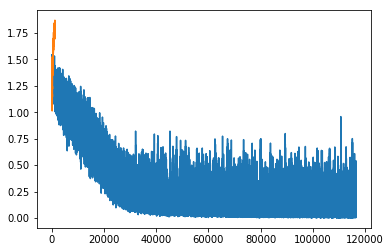

In [9]:
plt.plot(np.arange(0, len(train_loss), 1), train_loss)
plt.plot(np.arange(0, len(valid_loss), 1), valid_loss)
plt.show() # train과 validation 모두 봐야 한다.

## Model B : Build  --> Model A와 동일한 Structure이고, Optimizer만 Momentum으로 변경함

In [0]:
graph = tf.Graph()
with graph.as_default() :
    xs = tf.placeholder(tf.float32, (None, 32, 32, 3), name='xs') # 32*32 = 1024
    ys = tf.placeholder(tf.int32, (None), name='ys')
    lr = tf.placeholder_with_default(0.001, (), name='lr')
    
    with tf.name_scope('convolution_layer_1') :   ## filters is number of channels
        kernel_init = tf.random.normal(shape=[2, 2, 3, 16], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') # random normal 
        kernel= tf.Variable(kernel_init, name='kernel')               
        bias_init = tf.zeros([16])
        bias = tf.Variable(bias_init, name='bias')
    
        layer = tf.nn.conv2d(xs, kernel, strides=[1,1,1,1], padding='SAME') # convolution and add bias
        layer = layer + bias
        layer = tf.nn.relu(layer)
        
        pool = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)

    with tf.name_scope('convolution_layer_2') :   ## filters is number of channels
        kernel_init = tf.random.normal(shape=[2, 2, 16, 32], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') # random normal 
        kernel= tf.Variable(kernel_init, name='kernel')               
        bias_init = tf.zeros([32])
        bias = tf.Variable(bias_init, name='bias')
    
        layer = tf.nn.conv2d(pool, kernel, strides=[1,1,1,1], padding='SAME') # convolution and add bias   
        layer = layer + bias
        layer = tf.nn.relu(layer)
           
        pool = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)
        
            
    with tf.name_scope('convolution_layer_3') :   ## filters is number of channels
        kernel_init = tf.random.normal(shape=[3, 3, 32, 64], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') # random normal 
        kernel= tf.Variable(kernel_init, name='kernel')               
        bias_init = tf.zeros([64])
        bias = tf.Variable(bias_init, name='bias')    
        layer = tf.nn.conv2d(pool, kernel, strides=[1,1,1,1], padding='SAME') # convolution and add bias       
        layer = layer + bias
        layer = tf.nn.relu(layer)

        kernel_init2 = tf.random.normal(shape=[3, 3, 64, 64], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') # random normal 
        kernel2= tf.Variable(kernel_init2, name='kernel')               
        bias_init2 = tf.zeros([64])
        bias2 = tf.Variable(bias_init2, name='bias')    
        layer = tf.nn.conv2d(layer, kernel2, strides=[1,1,1,1], padding='SAME') # convolution and add bias   
        layer = layer + bias2
        layer = tf.nn.relu(layer)
    
        pool = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)        
        
    # receptive filed = 27, images size = 32, output imagesize = (4, 4)
    
    with tf.name_scope('Reconstruct') : 
        flatten = tf.layers.flatten(pool)
        layer = tf.layers.Dense(1024, activation=tf.nn.relu)(flatten) # 32*32
        layer = tf.layers.Dense(1024, activation=tf.nn.relu)(layer)
        y_pred = tf.layers.Dense(10, activation=None, name='y_pred')(layer)
        
    with tf.name_scope('Loss') :
        loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=ys, logits=y_pred))
        print(loss.shape)
        
    with tf.name_scope('metric') :
        rmse = tf.sqrt(loss)
    
    with tf.name_scope('accuracy') :
        pred = tf.cast(tf.arg_max(y_pred, 1), tf.int32)
        correct = tf.equal(pred, ys)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        # add tensor to tensorboard
        acc_tb = tf.summary.scalar(name='accuracy', tensor=accuracy)

    with tf.name_scope('train') :
        train_op = tf.train.MomentumOptimizer(lr, momentum=0.9, use_nesterov=False).minimize(loss)
        #train_op = tf.train.AdamOptimizer(lr).minimize(loss)

()


## Model B : Train

### Load trained weight and bias

In [0]:
from tensorflow.python.training import checkpoint_utils as cp

# 변수 불러오기
# print('저장된 변수의 이름을 불러옵니다')
var_names = cp.list_variables('./model/vgg_net')   # 변수와 shape를 가져온다. 저장된 data와 index에서 가져온다.
#print('저장된 변수의 이름 {}'.format(var_names))

# 값 불러오기
con_layer1_kernel  = cp.load_variable('./model/vgg_net' , 'convolution_layer_1/kernel')   
con_layer1_bias    = cp.load_variable('./model/vgg_net' , 'convolution_layer_1/bias')

con_layer2_kernel  = cp.load_variable('./model/vgg_net' , 'convolution_layer_2/kernel')   
con_layer2_bias    = cp.load_variable('./model/vgg_net' , 'convolution_layer_2/bias')

con_layer3_kernel1 = cp.load_variable('./model/vgg_net' , 'convolution_layer_3/kernel')   
con_layer3_bias1   = cp.load_variable('./model/vgg_net' , 'convolution_layer_3/bias')
con_layer3_kernel2 = cp.load_variable('./model/vgg_net' , 'convolution_layer_3/kernel_1')   
con_layer3_bias2   = cp.load_variable('./model/vgg_net' , 'convolution_layer_3/bias_1')

# print('con_layer1, kernel : {} bias : {}'.format(con_layer1_kernel[:1,:1,:1], con_layer1_bias[0]))

## Model B : Train

In [0]:
with graph.as_default() :
    
    # 텐서보드에 연결합니다. # sess.run보다 먼저 선언해야함. 
    log_dir = "./log/vgg_net"    
    tbc = tensorboardcolab.TensorBoardColab(graph_path = log_dir)
    
    train_writer = tf.summary.FileWriter(logdir = log_dir)
    train_writer.add_graph(tf.get_default_graph())
    merged_all = tf.summary.merge_all()    
    
    sess = tf.Session()
    # weight를 불러왔기 때문에 초기화를 하면 안됨!
    # sess.run(tf.global_variables_initializer()) 
    
    # Step2 : 기록
    saver = tf.train.Saver()
    
    # loading parameters
    saver.restore(sess, save_path='./model/vgg_net')
    # convolution_layer_1/kernel/Momentum <-- 얘를 초기화 하지 못함
    
    # Training
    batch_size = 30
    n_epoch = 2
    n_step = int(len(x_train) // batch_size)  # //은 몫이다.
    learing_rate = 0.0001
    
    # instance 생성
    train_generator = cifar_generator(x_train, y_train_label, batch_size)
    
    train_loss = []
    valid_loss = []
    valid_acc = []
    cnt = 0
    
    
    # Weight가 정상적으로 loading되었는지 확인함
    loss_, acc_ = sess.run([rmse, accuracy], feed_dict = { xs: x_validation, 
                                                           ys: y_validation_label})
    print("\n불러온 정보 확인! --> loss = {:.4f}, acc = {:.2f}%\n".format(loss_, acc_*100))
    
    print("Model B Train시작!\n")
    for i in tqdm(range(n_epoch)) :
        for step in range(n_step) :
            batch_xs, batch_ys = next(train_generator)
            _, train_loss_, tbs_train_ = sess.run([train_op, rmse, merged_all], feed_dict = { xs: batch_xs, 
                                                                                              ys: batch_ys, 
                                                                                              lr: learing_rate})
            train_writer.add_summary(tbs_train_, global_step=cnt) # 흠 되야 하는데 안된다.
            cnt += 1
            train_loss.append(train_loss_)
            if step % 100 == 0 :
                loss_, acc_ = sess.run([rmse, accuracy], feed_dict = { xs: x_validation, 
                                                                       ys: y_validation_label})
                valid_loss.append(loss_)
                valid_acc.append(acc_)
    print("loss = {:.4f}, acc = {:.2f}%".format(loss_, acc_*100))

    saver.save(sess, save_path='./model/vgg_net')
    
    train_writer.flush() # file을 disk에 쓴다

Wait for 8 seconds...
TensorBoard link:
https://cb18731d.ngrok.io


NotFoundError: ignored